In [203]:
%matplotlib inline

import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

tf.logging.set_verbosity(tf.logging.ERROR)
pandas.options.display.max_rows = 10
pandas.options.display.float_format = '{:.1f}'.format

In [54]:
features_train = pandas.read_csv(filepath_or_buffer='data/dengue_features_train.csv')
labels_train = pandas.read_csv(filepath_or_buffer='data/dengue_labels_train.csv')
features_test = pandas.read_csv(filepath_or_buffer='data/dengue_features_test.csv')

In [55]:
features_train.drop('week_start_date',axis=1,inplace=True)
features_test.drop('week_start_date',axis=1,inplace=True)

In [56]:
labels_train_sj = labels_train[labels_train.city == 'sj'].drop('city',axis=1)
labels_train_iq = labels_train[labels_train.city == 'iq'].drop('city',axis=1)
features_train_sj = features_train[features_train.city == 'sj'].drop('city',axis=1)
features_train_iq = features_train[features_train.city == 'iq'].drop('city',axis=1)
features_test_sj = features_test[features_test.city == 'sj'].drop('city',axis=1)
features_test_iq = features_test[features_test.city == 'iq'].drop('city',axis=1)

In [57]:
features_train_sj = features_train_sj.interpolate()
features_train_iq = features_train_iq.interpolate()
features_test_sj = features_test_sj.interpolate()
features_test_iq = features_test_iq.interpolate()

In [58]:
correlation_train = features_train.copy()

In [59]:
correlation_train['total_cases'] = labels_train['total_cases']
correlation_train['prev_total_cases'] = numpy.roll(labels_train['total_cases'], 1)

In [60]:
correlation_train_sj = correlation_train[correlation_train.city == 'sj'].drop('city',axis=1)
correlation_train_iq = correlation_train[correlation_train.city == 'iq'].drop('city',axis=1)

correlation_train_sj = correlation_train_sj.interpolate()
correlation_train_iq = correlation_train_iq.interpolate()

In [113]:
all_data_features_sj = features_train_sj.copy()
all_data_features_sj['total_cases'] = labels_train_sj['total_cases']

In [114]:
all_data_features_iq = features_train_iq.copy()
all_data_features_iq['total_cases'] = labels_train_iq['total_cases']

In [115]:
correlations_sj = all_data_features_sj.corr()
correlations_iq = all_data_features_iq.corr()

Text(0.5, 1.0, 'San Juan correlations')

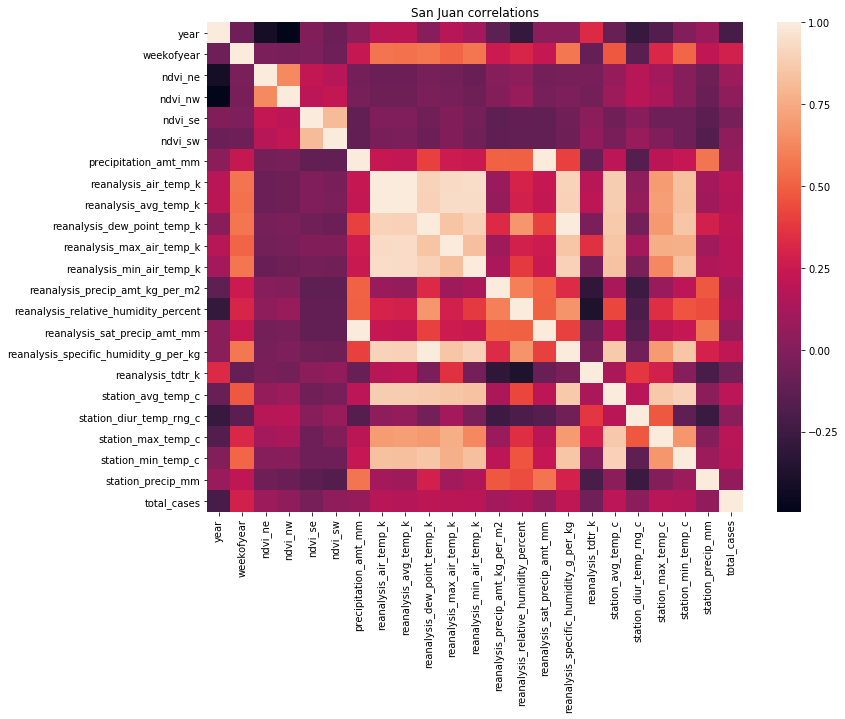

In [64]:
plt.figure(figsize=(12, 9))
correlations_sj_heatmap = seaborn.heatmap(correlations_sj)
plt.title('San Juan correlations')

Text(0.5, 1.0, 'Iquitos correlations')

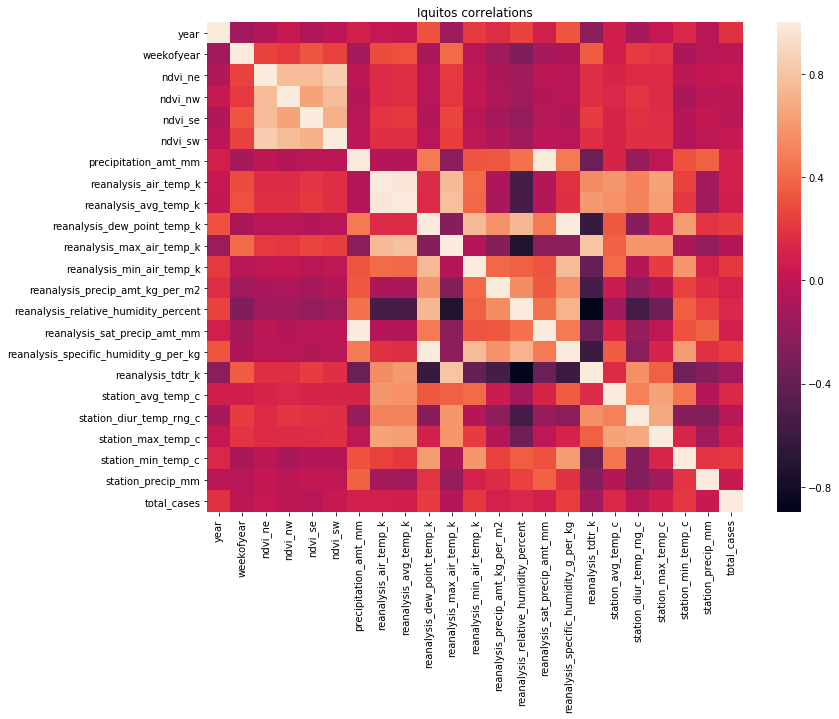

In [65]:
plt.figure(figsize=(12, 9))
correlations_iq_heatmap = seaborn.heatmap(correlations_iq)
plt.title('Iquitos correlations')

In [66]:
def preprocess_features(df):
    selected_features = df[
    ["year",
     "weekofyear",
     "ndvi_ne",
     "ndvi_nw",
     "ndvi_se",
     "ndvi_sw",
     "precipitation_amt_mm",
     "reanalysis_air_temp_k",
     "reanalysis_avg_temp_k",
     "reanalysis_dew_point_temp_k",
     "reanalysis_max_air_temp_k",
     "reanalysis_min_air_temp_k",
     "reanalysis_precip_amt_kg_per_m2",
     "reanalysis_relative_humidity_percent",
     "reanalysis_sat_precip_amt_mm",
     "reanalysis_specific_humidity_g_per_kg",
     "reanalysis_tdtr_k",
     "station_avg_temp_c",
     "station_diur_temp_rng_c",
     "station_max_temp_c",
     "station_min_temp_c",
     "station_precip_mm"]]
    processed_features = selected_features.copy()

    return processed_features

def preprocess_targets(df):
    output_targets = pandas.DataFrame()
    output_targets["total_cases"] = (df["total_cases"])
    return output_targets

In [67]:
print(features_train_sj.shape)
print(labels_train_sj.shape)

(936, 22)
(936, 3)


In [68]:
train_amount_sj = math.ceil(features_train_sj.shape[0] * 0.8)
validation_amount_sj = features_train_sj.shape[0] - train_amount_sj

training_examples_sj = preprocess_features(features_train_sj.head(train_amount_sj))
training_targets_sj = preprocess_targets(labels_train_sj.head(train_amount_sj))

validation_examples_sj = preprocess_features(features_train_sj.tail(validation_amount_sj))
validation_targets_sj = preprocess_targets(labels_train_sj.tail(validation_amount_sj))

test_examples_sj = preprocess_features(features_test_sj)

# # Double-check that we've done the right thing.
# print("Training examples summary:")
# display.display(training_examples_sj.describe())
# print("Validation examples summary:")
# display.display(validation_examples_sj.describe())

# print("Training targets summary:")
# display.display(training_targets_sj.describe())
# print("Validation targets summary:")
# display.display(validation_targets_sj.describe())

train_amount_iq = math.ceil(features_train_iq.shape[0] * 0.8)
validation_amount_iq = features_train_iq.shape[0] - train_amount_iq

training_examples_iq = preprocess_features(features_train_iq.head(train_amount_iq))
training_targets_iq = preprocess_targets(labels_train_iq.head(train_amount_iq))

validation_examples_iq = preprocess_features(features_train_iq.tail(validation_amount_iq))
validation_targets_iq = preprocess_targets(labels_train_iq.tail(validation_amount_iq))

test_examples_iq = preprocess_features(features_test_iq)

In [69]:
def construct_feature_columns(input_features):
      return set([tf.feature_column.numeric_column(xFeature)
              for xFeature in input_features])

In [70]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:numpy.array(value) for key,value in dict(features).items()}                                           
 
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(100)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [84]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    test_examples,
    city):

    periods = 10
    steps_per_period = steps / periods
  
    lin_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    lin_optimizer = tf.contrib.estimator.clip_gradients_by_norm(lin_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=lin_optimizer
    )

    training_input_fn = lambda: input_fn(training_examples, 
                                          training_targets["total_cases"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, 
                                                  training_targets["total_cases"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, 
                                                    validation_targets["total_cases"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    predict_test_input_fn = lambda: input_fn(test_examples,
                                                    training_targets["total_cases"].head(test_examples.shape[0]),
                                                    num_epochs=1, 
                                                    shuffle=False)

    print("Training model...")
    print("RMSE (on training data):")
    training_mae = []
    validation_mae = []
    for period in range (0, periods):
        linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
        )
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = numpy.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = numpy.array([item['predictions'][0] for item in validation_predictions])

        training_mean_absolute_error = metrics.mean_absolute_error(training_predictions, training_targets)
        validation_mean_absolute_error = metrics.mean_absolute_error(validation_predictions, validation_targets)

        print("  period %02d : %0.2f" % (period, training_mean_absolute_error))

        training_mae.append(training_mean_absolute_error)
        validation_mae.append(validation_mean_absolute_error)
    print("Model training finished.")
    
    test_predictions = linear_regressor.predict(input_fn= predict_test_input_fn)
    x = 0
    for ex in test_predictions:
      print(city + ',' + str(test_examples['year'].iloc[x]) + ',' + str(test_examples['weekofyear'].iloc[x]) + ',' + str(int(round(ex['predictions'][0],0))))
      x += 1

    plt.ylabel("MAE")
    plt.xlabel("Periods")
    plt.title("Mean Absolute Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_mae, label="training")
    plt.plot(validation_mae, label="validation")
    plt.legend()

    return linear_regressor

In [ ]:
_sj = train_model(
    learning_rate=0.0003,
    steps=400,
    batch_size=10,
    feature_columns=construct_feature_columns(training_examples_sj),
    training_examples=training_examples_sj,
    training_targets=training_targets_sj,
    validation_examples=validation_examples_sj,
    validation_targets=validation_targets_sj,
    test_examples=test_examples_sj,
    city='sj')

In [ ]:
_iq = train_model(
    learning_rate=0.0003,
    steps=400,
    batch_size=10,
    feature_columns=construct_feature_columns(training_examples_iq),
    training_examples=training_examples_iq,
    training_targets=training_targets_iq,
    validation_examples=validation_examples_iq,
    validation_targets=validation_targets_iq,
    test_examples=test_examples_iq,
    city='iq')

In [75]:
# regressor = tf.contrib.learn.DNNRegressor(feature_columns = feature_columns, 
#                                           activation_fn = tf.nn.relu, hidden_units=[250, 100, 50])

In [116]:
all_data_features_sj.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,0.1,0.1,0.2,0.2,12.4,297.6,297.7,292.4,...,73.4,12.4,14.0,2.6,25.4,6.9,29.4,20.0,16.0,4
1,1990,19,0.2,0.1,0.2,0.2,22.8,298.2,298.4,294.0,...,77.4,22.8,15.4,2.4,26.7,6.4,31.7,22.2,8.6,5
2,1990,20,0.0,0.2,0.2,0.2,34.5,298.8,298.9,295.4,...,82.1,34.5,16.8,2.3,26.7,6.5,32.2,22.8,41.4,4
3,1990,21,0.1,0.2,0.2,0.2,15.4,299.0,299.2,295.3,...,80.3,15.4,16.7,2.4,27.5,6.8,33.3,23.3,4.0,3
4,1990,22,0.2,0.3,0.3,0.2,7.5,299.5,299.7,295.8,...,80.5,7.5,17.2,3.0,28.9,9.4,35.0,23.9,5.8,6


In [117]:
col_train_sj = list(all_data_features_sj.columns)

In [118]:
print(col_train_sj)

['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'total_cases']


In [122]:
col_train_sj_bis = col_train_sj.copy()
col_train_sj_bis.remove('total_cases')
mat_train = numpy.matrix(all_data_features_sj)
mat_new = numpy.matrix(all_data_features_sj.drop('total_cases',axis=1))
mat_y = numpy.array(all_data_features_sj.total_cases)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(936,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pandas.DataFrame(prepro.transform(mat_train),columns = col_train_sj)
all_data_features_sj_scale = all_data_features_sj.copy()
all_data_features_sj_scale[col_train_sj] = pandas.DataFrame(prepro.transform(mat_train),columns = col_train_sj)

/home/chamath/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [121]:
all_data_features_sj.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,0.1,0.1,0.2,0.2,12.4,297.6,297.7,292.4,...,73.4,12.4,14.0,2.6,25.4,6.9,29.4,20.0,16.0,4
1,1990,19,0.2,0.1,0.2,0.2,22.8,298.2,298.4,294.0,...,77.4,22.8,15.4,2.4,26.7,6.4,31.7,22.2,8.6,5
2,1990,20,0.0,0.2,0.2,0.2,34.5,298.8,298.9,295.4,...,82.1,34.5,16.8,2.3,26.7,6.5,32.2,22.8,41.4,4
3,1990,21,0.1,0.2,0.2,0.2,15.4,299.0,299.2,295.3,...,80.3,15.4,16.7,2.4,27.5,6.8,33.3,23.3,4.0,3
4,1990,22,0.2,0.3,0.3,0.2,7.5,299.5,299.7,295.8,...,80.5,7.5,17.2,3.0,28.9,9.4,35.0,23.9,5.8,6


In [123]:
all_data_features_sj_scale.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0.0,0.3,0.6,0.6,0.5,0.5,0.0,0.3,0.3,0.3,...,0.3,0.0,0.3,0.4,0.4,0.4,0.3,0.3,0.1,0.0
1,0.0,0.3,0.6,0.7,0.4,0.5,0.1,0.4,0.4,0.5,...,0.5,0.1,0.5,0.3,0.5,0.3,0.6,0.6,0.0,0.0
2,0.0,0.4,0.5,0.7,0.4,0.5,0.1,0.5,0.5,0.7,...,0.7,0.1,0.7,0.3,0.5,0.4,0.6,0.6,0.1,0.0
3,0.0,0.4,0.6,0.8,0.6,0.7,0.0,0.5,0.5,0.7,...,0.7,0.0,0.6,0.3,0.6,0.4,0.7,0.7,0.0,0.0
4,0.0,0.4,0.7,0.8,0.7,0.7,0.0,0.6,0.6,0.8,...,0.7,0.0,0.7,0.5,0.8,0.9,0.9,0.8,0.0,0.0


In [126]:
training_set_sj = all_data_features_sj
prediction_set = training_set_sj.total_cases

In [127]:
COLUMNS = col_train_sj
FEATURES = col_train_sj_bis
LABEL = "total_cases"

In [139]:
engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

In [132]:
x_train, x_test, y_train, y_test = train_test_split(training_set_sj,
                                                    prediction_set, test_size=0.2, random_state=42)

In [133]:
y_train = pandas.DataFrame(y_train, columns = [LABEL])
training_set = pandas.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)

y_test = pandas.DataFrame(y_test, columns = [LABEL])
testing_set = pandas.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

In [181]:
test_set_sj = pandas.DataFrame(features_test_sj, columns= FEATURES)
test_set_iq = pandas.DataFrame(features_test_iq, columns= FEATURES)

In [184]:
def input_fn_new(data_set, training):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    feature_cols = dict(list(continuous_cols.items()))
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

# Outputs the feature columns and labels
        return feature_cols, label
    
    return feature_cols

In [185]:
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[250, 100, 50])

In [188]:
regressor.fit(input_fn = lambda: input_fn_new(training_set, training=True) , steps=10000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f1e59840898>, 'hidden_units': [250, 100, 50], 'feature_columns': (_RealValuedColumn(column_name='year', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='weekofyear', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='ndvi_ne', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='ndvi_nw', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='ndvi_se', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='ndvi_sw', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='precipitation_amt_mm', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='reanaly

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))

import matplotlib.pyplot as plt
import matplotlib
import itertools

ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))
reality = pandas.DataFrame(testing_set).total_cases

In [ ]:
print(testing_set.shape)
print(reality.shape)

In [ ]:
reality.head()

In [ ]:
testing_set.head()

In [ ]:
y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))
predictions = pandas.DataFrame(numpy.array(predictions).reshape(188,1))

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

fig, ax = plt.subplots(figsize=(15, 12))
plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [194]:
z = regressor.predict(input_fn=lambda: input_fn_new(test_set_sj, training=False))
predict_cases = list(itertools.islice(z, test_set_sj.shape[0]))
predict_cases = pandas.DataFrame(numpy.array(predict_cases).reshape(260,1))

In [195]:
test_set_sj.shape

(260, 22)

In [196]:
print(predict_cases)

       0
0   28.5
1   26.1
2   27.9
3   26.7
4   22.2
..   ...
255 21.8
256 32.0
257 21.7
258 21.3
259 25.2

[260 rows x 1 columns]


In [197]:
predict_cases.to_csv('data/dengue_predict_sj_test.csv', sep='\t', encoding='utf-8')

In [198]:
test_set_iq.shape

(156, 22)

In [199]:
zz = regressor.predict(input_fn=lambda: input_fn_new(test_set_iq, training=False))
predict_cases_iq = list(itertools.islice(zz, test_set_iq.shape[0]))
predict_cases_iq = pandas.DataFrame(numpy.array(predict_cases_iq).reshape(156,1))

In [200]:
predict_cases_iq.to_csv('data/dengue_predict_iq_test.csv', sep='\t', encoding='utf-8')